## Evaluate Weather Detection
This python notebook is designed to perform detailed analysis of the latest saved weather detection model from optimized_weather_training_pipeline.ipynb.

**Goal**: Conduct testing on sample weather sound datasets to assess model performance.

### Notebook Overview:
- **Generate Predictions**: Runs over all specified labels for which the weather detection model is trained for and generates their predictions
- **Evaluate Results**: Calculates performance metrics like f1-score, accuracy,precision,recall
- **Confusion matrix**: Generates confusion matrix over the labels


## Generate predictions
Loops over audio to generate predictions and create a Dataframe with predicted and actual label. Results are saved in a timestamped csv file predicted_results_{datetime}. This file can be used to see performance of previous versions of the model even if we don't have the model file anymore.

**Important note**: Update the label_paths array if more label predictions is introduced to the model

### Configuration Dictionary for Audio Processing and Model Input

The `SC` dictionary contains configuration settings that are essential for the audio preprocessing and the CNN model input preparation. Below are the details of each configuration:

### Audio Processing Parameters:
- **AUDIO_CLIP_DURATION**: The duration of the audio clip in seconds. Each audio file is processed to have this fixed length (2 seconds).
- **AUDIO_NFFT**: The number of FFT (Fast Fourier Transform) points used to calculate the mel-spectrogram (2048 points).
- **AUDIO_WINDOW**: The windowing function used in the FFT. It is set to `None`, meaning librosa's default will be used.
- **AUDIO_STRIDE**: The stride (hop length) between successive FFTs during the spectrogram calculation (200 samples).
- **AUDIO_SAMPLE_RATE**: The sampling rate used for audio files (16000 Hz).
- **AUDIO_MELS**: The number of Mel bands used in the mel-spectrogram (260 bands).
- **AUDIO_FMIN**: The lowest frequency to include when generating the mel-spectrogram (20 Hz).
- **AUDIO_FMAX**: The highest frequency to include when generating the mel-spectrogram (13000 Hz).
- **AUDIO_TOP_DB**: The threshold for the top decibels used in the dynamic range compression during log mel-spectrogram generation (80 dB).

### Model Input Specifications:
- **MODEL_INPUT_IMAGE_WIDTH**: The width of the input images to the CNN model (260 pixels).
- **MODEL_INPUT_IMAGE_HEIGHT**: The height of the input images to the CNN model (260 pixels).
- **MODEL_INPUT_IMAGE_CHANNELS**: The number of channels in the input images to the CNN model, corresponding to RGB channels (3 channels).

These parameters are critical in ensuring that the audio data is uniformly processed and prepared in a format suitable for the CNN model training, helping in achieving consistent results and effective learning.


In [7]:
import os
import librosa
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

SC = {
    'AUDIO_CLIP_DURATION': 2,
    'AUDIO_NFFT': 2048,
    'AUDIO_WINDOW': None,
    'AUDIO_STRIDE': 200,
    'AUDIO_SAMPLE_RATE': 16000,
    'AUDIO_MELS': 260,
    'AUDIO_FMIN': 20,
    'AUDIO_FMAX': 13000,
    'AUDIO_TOP_DB': 80,
}

def load_and_pad_audio(file_path, duration=2, sr=16000):
    audio, _ = librosa.load(file_path, sr=sr)
    required_samples = sr * duration
    if len(audio) < required_samples:
        audio = np.pad(audio, (0, required_samples - len(audio)), 'constant')
    else:
        audio = audio[:required_samples]
    return audio, sr

def prepare_audio(file_path):
    audio, sr = load_and_pad_audio(file_path, duration=SC['AUDIO_CLIP_DURATION'], sr=SC['AUDIO_SAMPLE_RATE'])
    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio, sr=sr,
        n_fft=SC['AUDIO_NFFT'],
        hop_length=SC['AUDIO_STRIDE'],
        n_mels=SC['AUDIO_MELS'],
        fmin=SC['AUDIO_FMIN'],
        fmax=SC['AUDIO_FMAX']
    )
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, top_db=SC['AUDIO_TOP_DB'])
    spectrogram_resized = tf.image.resize(log_mel_spectrogram[np.newaxis, :, :, np.newaxis], [260, 260])
    spectrogram_resized = np.repeat(spectrogram_resized, 3, axis=-1)
    return spectrogram_resized


# Set the directory path containing the audio files
directory_path = r"D:\Deakin\Project Echo\Weather_Sounds\Weather_Sounds"

# Load the trained model
model = load_model('WeatherAudioDetectionModel_T2_2024_100.h5')

# Create a label encoder
encoder = LabelEncoder()
encoder.fit(['Earthquake', 'Rain', 'Thunder', 'Tornado'])

# Initialize an empty list to store the predictions
predictions_list = []

label_paths = ["Earthquake","Rain","Thunder","Tornado"]

# Loop over the subdirectories in the main directory
# for subdir in os.listdir(directory_path):
for subdir in label_paths:
    subdir_path = os.path.join(directory_path, subdir)
    if os.path.isdir(subdir_path):
        # Loop over the files in each subdirectory
        for filename in os.listdir(subdir_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(subdir_path, filename)
                # print(file_path)
                # Prepare the audio spectrogram
                input_spectrogram = prepare_audio(file_path)
                
                # Make predictions
                predictions = model.predict(input_spectrogram)
                predicted_class = np.argmax(predictions, axis=1)
                
                if predicted_class.size == 1:
                    predicted_class = predicted_class.item()
                
                predicted_label = encoder.inverse_transform([predicted_class])
                
                max_probability = np.max(predictions)
                
                confidence_threshold = 0.7
                if max_probability > confidence_threshold:
                    confidence = "High"
                else:
                    confidence = "Low"
                
                # Append the predictions to the list
                predictions_list.append({
                    "File": filename,
                    "Actual-Label": subdir,
                    # "Predicted Class Index": predicted_class,
                    "Predicted-Label": predicted_label[0],
                    # "Class Probabilities": predictions.flatten(),
                    # "Highest Class Probability": max_probability,
                    # "Confidence": confidence
                })

# Create a DataFrame from the predictions list
predictions_df = pd.DataFrame(predictions_list)

# Print the DataFrame
print(predictions_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━

In [8]:
import pandas as pd
# Create a DataFrame from the predictions list
predictions_df = pd.DataFrame(predictions_list)

# Print the DataFrame
print(predictions_df)

                                File Actual-Label Predicted-Label
0             region_0.100-0.450.wav   Earthquake      Earthquake
1             region_0.100-4.100.wav   Earthquake      Earthquake
2             region_0.150-4.150.wav   Earthquake      Earthquake
3             region_0.700-4.700.wav   Earthquake      Earthquake
4             region_1.050-5.050.wav   Earthquake      Earthquake
...                              ...          ...             ...
11722   region_9985.250-9986.700.wav      Tornado         Tornado
11723   region_9986.800-9990.800.wav      Tornado         Tornado
11724   region_9990.800-9994.800.wav      Tornado         Tornado
11725   region_9994.800-9998.800.wav      Tornado         Tornado
11726  region_9998.800-10002.800.wav      Tornado         Tornado

[11727 rows x 3 columns]


In [9]:
from datetime import datetime
now = datetime.now()
date_string = now.strftime('%d_%m_%Y_%h')
print(f"Current date: {date_string}")
predictions_df.to_csv(f'predicted_results_{date_string}')

Current date: 17_09_2024_Sep


## Evaluate results
Once the predicted_df is populated on your desired test set run below to see evaluation of each label.

Alternatively you can load the predicted_results_{datetime}.csv file into predictions_df df.

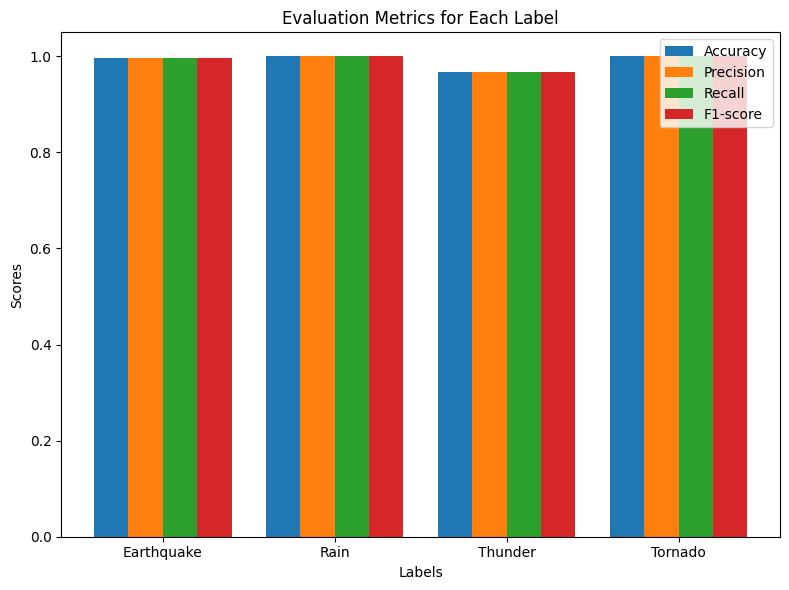

In [10]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame called 'df'
# with columns 'filename', 'true_label', and 'predicted_label'

# Get the unique labels
labels = predictions_df['Actual-Label'].unique()

# Calculate evaluation metrics for each label
accuracies = []
precisions = []
recalls = []
f1_scores = []

for label in labels:
    true_labels = predictions_df[predictions_df['Actual-Label'] == label]['Actual-Label']
    predicted_labels = predictions_df[predictions_df['Actual-Label'] == label]['Predicted-Label']
    
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, pos_label=label, average='micro')
    recall = recall_score(true_labels, predicted_labels, pos_label=label, average='micro')
    f1 = f1_score(true_labels, predicted_labels, pos_label=label, average='micro')
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Create a bar graph to visualize the accuracy for each label
fig, ax = plt.subplots(figsize=(8, 6))
x = range(len(labels))
width = 0.2

ax.bar(x, accuracies, width, label='Accuracy')
ax.bar([i + width for i in x], precisions, width, label='Precision')
ax.bar([i + 2 * width for i in x], recalls, width, label='Recall')
ax.bar([i + 3 * width for i in x], f1_scores, width, label='F1-score')

ax.set_xlabel('Labels')
ax.set_ylabel('Scores')
ax.set_title('Evaluation Metrics for Each Label')
ax.set_xticks([i + 1.5 * width for i in x])
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()

## Confusion matrix

Generate confusion matrix to understand which labels are being mispredicted.

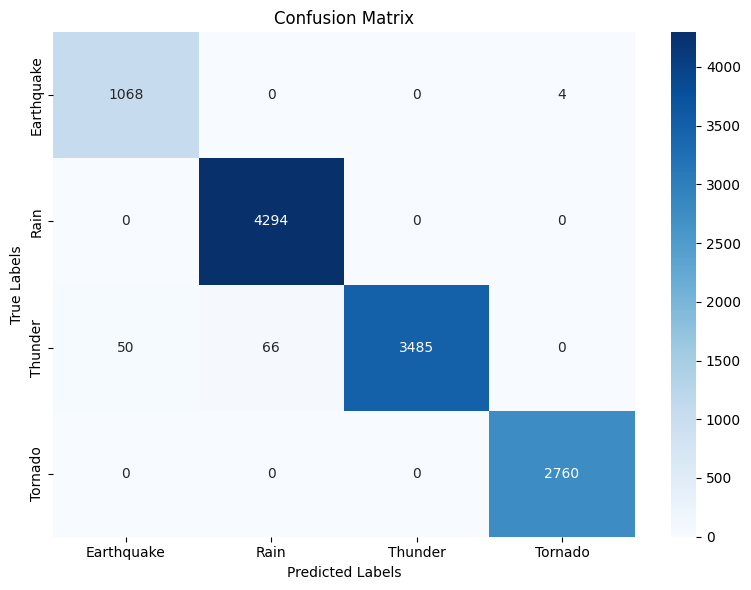

In [11]:
import seaborn as sns


cm = confusion_matrix(predictions_df['Actual-Label'], predictions_df['Predicted-Label'], labels=labels)

# Plot the confusion matrix as a heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

plt.tight_layout()
plt.show()

## Improvement Report T1 2024
**Abstract**: Improvements achieved in the task of weather detection , i.e accurately detecting and classifying weather sounds.

### Initial state:
According to task description on trello for weather detection optimisation, there was an existing model trained and its model file saved. This was a model trained on a different dataset and was not useful for us anymore. Therefore, an entirely new model on a new architecure was trained using our weather sounds dataset. https://deakin365-my.sharepoint.com/:u:/r/personal/s222523115_deakin_edu_au/Documents/Weather_Sounds.zip?csf=1&web=1&e=Ft7M2T

### Work done:
Following are the improvements made.
- Preprocessing:
    1. load and pad audio. 
    2. loading audio files.
    3. prepare spectogram and data splitting for training.
- Model:

    1.  Details for model architecture can be found in 'optimized_weather_training_pipeline.ipynb'
    2.  Model training setup and callbacks
    3.  Model is trained for labels 'earthquake','rain','thunder','tornado'.
    4.  First 100 audio files for each label were used for training.
- Model Save: 
    1. Model saved in directory 'weather_audio_detection'.
    2. Saved as TensorFlow SavedModel. This is done for future training and transferlearning tasks
    3. Saved as HDf5 file. For versatility and abilty to load model in other envrionments.
- Mode evaluate:
    1. Set up evaluation script 'evaluate_weatherDetection'
    2. Generate results of model over test set of 10,000 audio files.
    3. Save results as timestamped csv file. This is for easy comparison with any new iterations of the weather model.
    3. Model has very high accuracy, precision , recall, across all labels. Details can be seen in evaluation script.
    4. label 'thunder' has a relatively more chance of being mislabeled as rain. Assume this is due to overlaps of both type of sounds.
    5. label 'eathquake' is not properly evaluated, need more test data to get true result for this.
     



## Improvement Report T2 2024
**Abstract**: Improvements achieved in the task of weather detection , i.e accurately detecting and classifying weather sounds.

### Initial state:
Model suffered from not having good class balance. Namely it was the earthquake label. The dataset was not consolidated properly as it was stored in a deakin share point folder instead of a google bucket and maintaining the files was difficult.

- Mode evaluate:
    1. Source and expand earthquake data
    2. Consolidate weather sounds to a single bucket
    3. Generate results of model over test set of 11,000 audio files.
    4. improve earthquake label imbalance.
    5. Model has very high accuracy, precision , recall, across all labels. Details can be seen in evaluation script.
    6. label 'thunder' has a relatively more chance of being mislabeled as rain. Assume this is due to overlaps of both type of sounds.
     


